<a href="https://colab.research.google.com/github/RGologorsky/fastmri/blob/master/04_kspace_classifier_real_imagenette.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classifying real images in kspace

- Can a CNN learn to classify given kspace as input?
- Can we apply audio (time freq) techniques to kspace (spacial freq)?
  - MELGAN, MEL Spectogram, MFCC (http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)
  - Audio data augs

- Do max pooling layers help?

MRI scans have correct orientation; max pooling loses spacial info "ignores the relation between the part and the whole"
-- maybe try CNNs without max pooling?

![Max pooling, same features](https://miro.medium.com/max/1400/1*wsf4tsOH77T1lpylPUIhbA.png)

## Setup

In [8]:
# clone repo
!git clone https://github.com/RGologorsky/fastmri.git

# pip install/import
%run "$PROJ/common_constants_env.ipynb" # pip install fastai, fastmri, etc
%run "$PROJ/01_kspace_tfms.ipynb"       # get the kspace tfms

Cloning into 'fastmri'...
remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 240 (delta 76), reused 142 (delta 31), pack-reused 0
Receiving objects: 100% (240/240), 13.09 MiB | 5.90 MiB/s, done.
Resolving deltas: 100% (76/76), done.
pip install fastai2
git clone fastMRI
pip install ISMRMRD
pip install fasMRI req
sys append /content/fastMRI
imports


# Save/Export

Set export path (save model arch + weights)

1. Save in local github folder
2. Save in gdrive folder

Remember to PUSH after saving!

In [9]:
save_local = False
PROJ       = "fastmri"

from google.colab import drive # import drive from google colab
from pathlib import Path

if save_local: EXPORT_DIR = f"{PROJ}/exports"
else: 
  # Mount Google Drive 
  ROOT = "/content/drive"     # default location for the drive
  drive.mount(ROOT)           # mount google drive at /content/drive

  # set folder path in gdrive
  EXPORT_DIR = Path(ROOT)/"My Drive/fastai_proj"/PROJ/"exports"
  EXPORT_DIR.mkdir(parents=True, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
EXPORT_DIR

Path('/content/drive/My Drive/fastai_proj/fastmri/exports')

## Data

Imagenette

In [11]:
url = URLs.IMAGENETTE_160 # sizes = 28x28

# download & unpack data in url
path = untar_data(url)
fnames = get_image_files(path)

In [0]:
# for Imagenette data

# convert filename stem to category
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)


### Test tfms on data

Batch of images: tensor of shape torch.Size([10, 128, 128])
Batch in kspace: tensor of shape torch.Size([10, 128, 128, 2])
Batch kspace2img: tensor of shape torch.Size([10, 128, 128])
Batch log abs kspace: tensor of shape torch.Size([10, 128, 128])


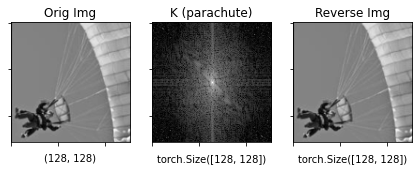

In [13]:
# batch BW images
bslice = slice(11_000,11_010)
xb = [RandomResizedCrop(128, min_scale=0.35)(PILImageBW.create(fn)) for fn in fnames[bslice]]
yb = [lbl_dict.__getitem__(parent_label(fn)) for fn in fnames[bslice]]

# im2tensor
t_xb = torch.stack(tuple(apply(x, TensorTfms.im2arr) for x in xb), dim=0)
print(f"Batch of images: tensor of shape {t_xb.shape}")

# im2kspace
k_xb = apply(t_xb, TensorTfms.real2k(onesided=False))
print(f"Batch in kspace: tensor of shape {k_xb.shape}")

# decodes
rev_xb = apply(k_xb, TensorTfms.k2real(onesided=False))
print(f"Batch kspace2img: tensor of shape {rev_xb.shape}")

# kspace abs
k_abs_xb = apply(k_xb, TensorTfms.log_abs, pre=TensorTfms.t_abs)
print(f"Batch log abs kspace: tensor of shape {k_abs_xb.shape}")

# plot an item in xb
i = 1
plot([xb[i], k_abs_xb[i], rev_xb[i]], [f"Orig Img", f"K ({yb[i]})", f"Reverse Img"])


# Dataset

Audio Data augs? Normalize?


total, train, valid, train+valid: 13394, 9469, 3925, 13394
(#10) ['English springer','French horn','cassette player','chain saw','church','garbage truck','gas pump','golf ball','parachute','tench']


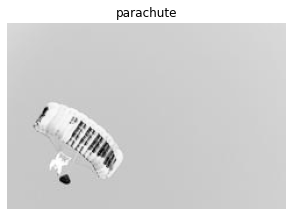

In [14]:
raw_items = fnames

x_tfms = [PILImageBW.create]
y_tfms = [parent_label, lbl_dict.__getitem__, Categorize]

splitter = GrandparentSplitter(valid_name='val')
splits   = splitter(raw_items)

#splitter = GrandparentSplitter(valid_name="val")
#splittter = RandomSplitter(valid_pct=0.2, seed=42)

dsets = Datasets(raw_items, tfms = [x_tfms, y_tfms], splits=splits)

# print info

# print how many items in total, in train, and in valid
ntotal, ntrain, nvalid = len(raw_items), len(dsets.train), len(dsets.valid)
print(f"total, train, valid, train+valid: {ntotal}, {ntrain}, {nvalid}, {ntrain+nvalid}")

# show an (x,y) item in the dataset
dsets.show(dsets[11_000])

# vocab
print(dsets.vocab)

# Dataloaders

Define parameters

In [0]:
bs = 64
num_workers = 1

Define dataloaders (learning in image space)

In [0]:
# define size of ims after item/batching (to use in defining cnn)
item_sz, batch_sz = 128,128

item_tfms  = [ToTensor, RandomResizedCrop(item_sz, min_scale=0.35)]
batch_tfms = [IntToFloatTensor] # Normalize? SaveShape

im_dls = dsets.dataloaders(
          after_item  = item_tfms, 
          after_batch = batch_tfms, 
          bs=bs, 
          num_workers = num_workers).cuda()


(None,
 (#10) ['English springer','French horn','cassette player','chain saw','church','garbage truck','gas pump','golf ball','parachute','tench'])

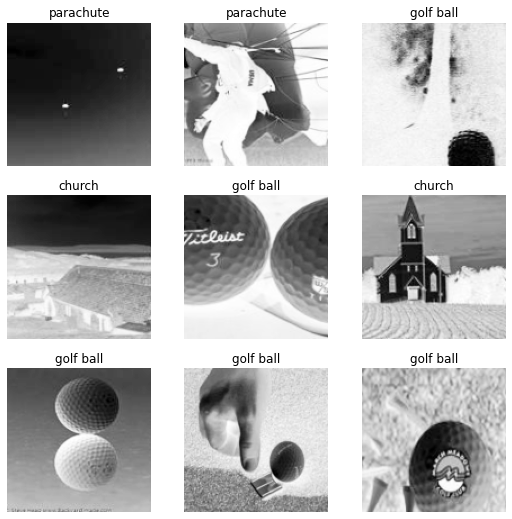

In [17]:
# show im_dls
im_dls.show_batch(), im_dls.vocab

Define dataloaders (learning in complex kspace)

In [0]:
item_sz, batch_sz = 128,128

k_item_tfms  = [ToTensor, RandomResizedCrop(item_sz, min_scale=0.35)]
k_batch_tfms = [IntToFloatTensor, BatchReal2ComplexK, Complex2Channel] # Normalize? SaveShape

k_dls = dsets.dataloaders(
          after_item  = k_item_tfms, 
          after_batch = k_batch_tfms, 
          bs=bs, 
          num_workers = num_workers).cuda()

Batch kspace2img: tensor of shape torch.Size([64, 128, 128])
Batch log abs kspace: tensor of shape torch.Size([64, 128, 128])


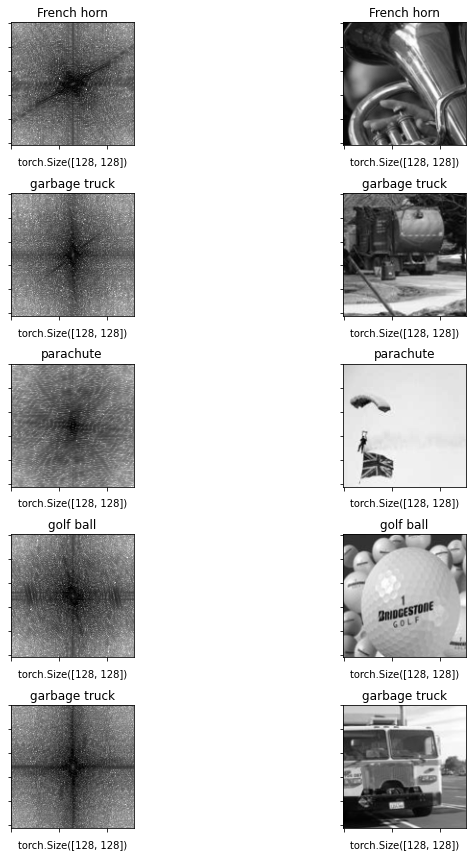

In [19]:
# get batch
k_xb, yb = k_dls.one_batch()
k_xb, yb = to_cpu(k_xb), to_cpu(yb)

# decodes
rev_k_xb = apply(Complex2Channel().decodes(k_xb), TensorTfms.batch_k2real(onesided=False))
print(f"Batch kspace2img: tensor of shape {rev_k_xb.shape}")

# kspace abs
abs_k_xb = apply(Complex2Channel().decodes(k_xb), TensorTfms.log_abs, pre=TensorTfms.t_abs)
print(f"Batch log abs kspace: tensor of shape {abs_k_xb.shape}")

# plot item in batch

# select slice
nb = 5
bslice = slice(0,nb)

# set titles/order of images to plot
titles = [x for i in range(nb) for x in [f"{k_dls.vocab[yb[i]]}",  f"{k_dls.vocab[yb[i]]}"]]
imgs   = [x for i in range(nb) for x in [abs_k_xb[i], rev_k_xb[i]]]

# plot
plot(imgs, titles, nrows=nb, ncols=2, figsize=(12,12))

Define dataloaders (learning in log amp kspace)

In [0]:
item_sz, batch_sz = 128,128

k_abs_item_tfms  = [ToTensor, RandomResizedCrop(item_sz, min_scale=0.35)]
k_abs_batch_tfms = [IntToFloatTensor, BatchReal2ComplexK, ComplexK2LogAbs] # Normalize? SaveShape

k_abs_dls = dsets.dataloaders(
          after_item  = k_abs_item_tfms, 
          after_batch = k_abs_batch_tfms, 
          bs=bs, 
          num_workers = num_workers).cuda()

## print in a row

In [21]:
# 10 different categories
k_dls.vocab

(#10) ['English springer','French horn','cassette player','chain saw','church','garbage truck','gas pump','golf ball','parachute','tench']

Batch of 10 categories in kspace (5 examples of each category):
 tensor of shape torch.Size([48, 2, 128, 128])
Batch img (kspace to img): tensor of shape torch.Size([48, 128, 128])
Batch log abs kspace: tensor of shape torch.Size([48, 128, 128])


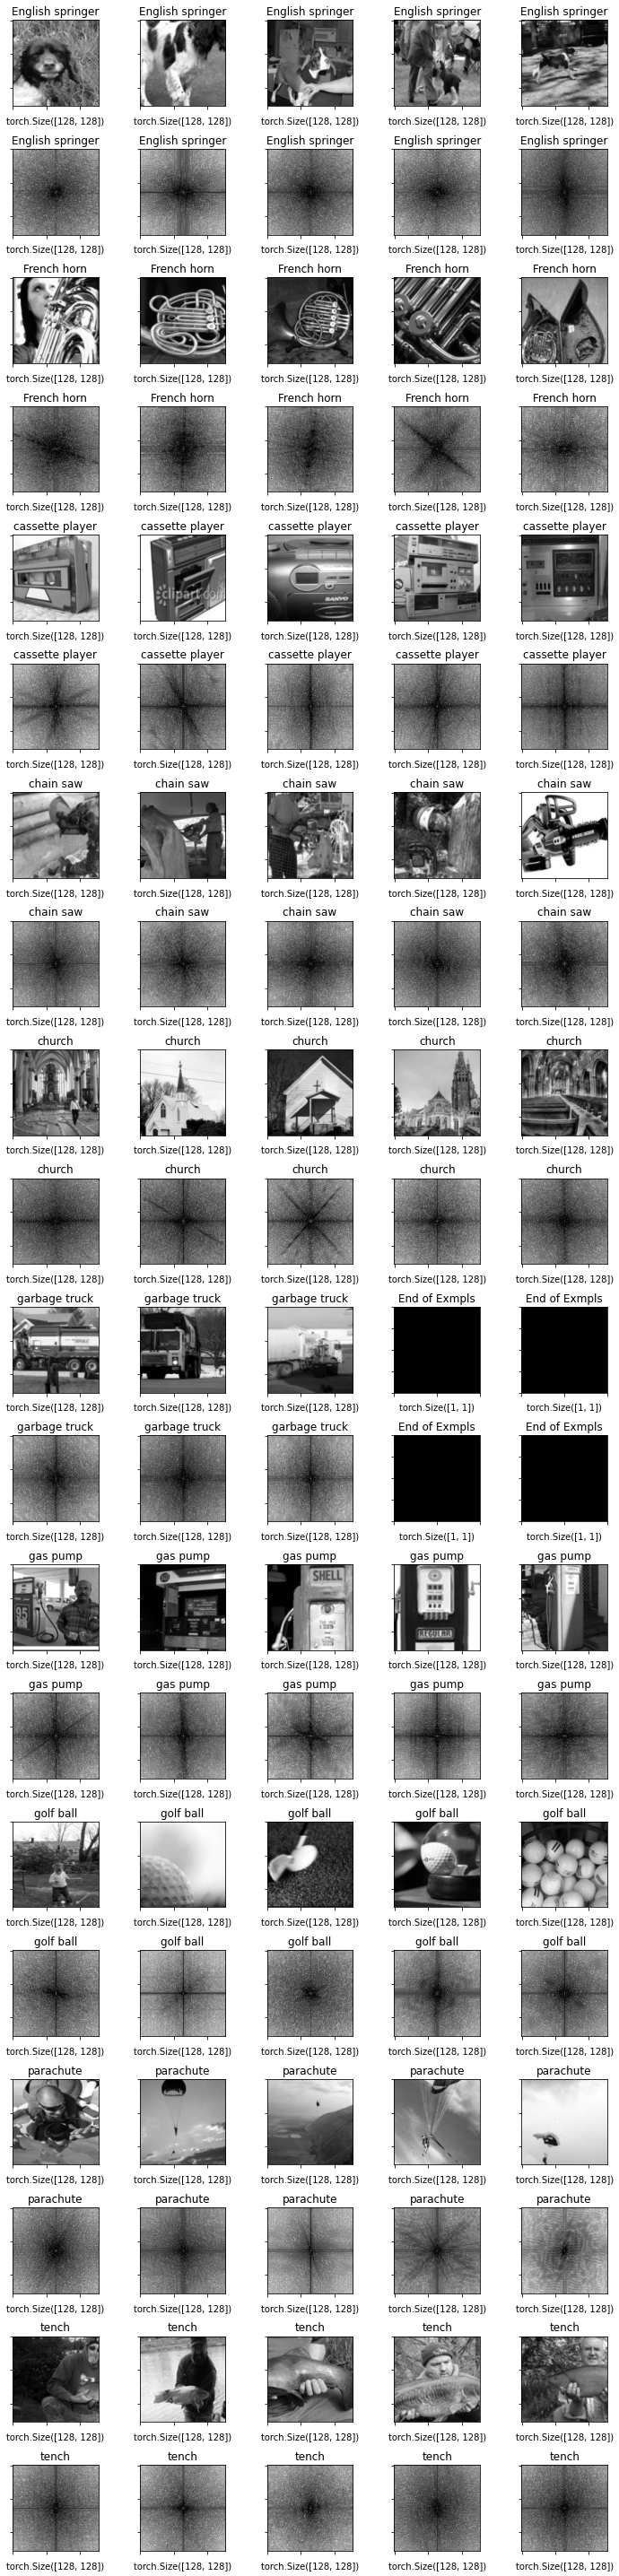

In [22]:
# set max num examples to show per class (ncols)
ncols = 5

# nrows = number of classes/categories
ncat = len(k_dls.vocab)

# get random batch (512 bs)
kxb, yb = k_dls.one_batch()
kxb, yb = to_cpu(kxb), to_cpu(yb)

# grab 5 examples of each category
kxbd = torch.cat(tuple(kxb[yb==cat][:ncols] for cat in range(ncat)), dim = 0)
ybd  = torch.cat(tuple( yb[yb==cat][:ncols] for cat in range(ncat)), dim = 0)
print(f"Batch of 10 categories in kspace ({ncols} examples of each category):\n tensor of shape {kxbd.shape}")

# decodes
rev_kxbd = apply(Complex2Channel().decodes(kxbd), TensorTfms.batch_k2real(onesided=False))
print(f"Batch img (kspace to img): tensor of shape {rev_kxbd.shape}")

# kspace abs
abs_kxbd = apply(Complex2Channel().decodes(kxbd), TensorTfms.log_abs, pre=TensorTfms.t_abs)
print(f"Batch log abs kspace: tensor of shape {abs_kxbd.shape}")

# plot item in batch

# how many examples of each category are there in each category
ncols_in_cat = {cat: len(yb[yb==cat][:ncols]) for cat in range(ncat)}

# create a list of imgs and titles
imgs   = L()
titles = L()

# default if there are no further examples of desired category
empty_img   = L(torch.zeros(1,1))
empty_title = L("End of Exmpls")

kidx = 0
for cat in range(ncat):
  # say we want 5 examples per category but only have 3 here:ncols_eff=3,empty=2
  ncols_eff  = ncols_in_cat[cat]
  n_empty    = ncols - ncols_eff

  # add a row of images (in real image space), pad with empty image
  imgs += L(rev_kxbd[kidx + i] for i in range(ncols_eff)) + empty_img * n_empty
  imgs += L(abs_kxbd[kidx + i] for i in range(ncols_eff)) + empty_img * n_empty

  # add titles for two rows (titles identical for these two rows)
  titles += (L(f"{k_dls.vocab[ybd[kidx + i]]}" for i in range(ncols_eff)) + empty_title * n_empty)*2

  kidx += ncols_eff

# plot
plot(imgs, titles, nrows=2*ncat, ncols=ncols, figsize=(ncols*2,ncat*4))

Digit 9 batch: torch.Size([6, 2, 128, 128]), torch.Size([6])
Indices of 9 in batch: [10 20 21 24 28 33]
Batch kspace2img: tensor of shape torch.Size([6, 128, 128])
Batch log abs kspace: tensor of shape torch.Size([6, 128, 128])


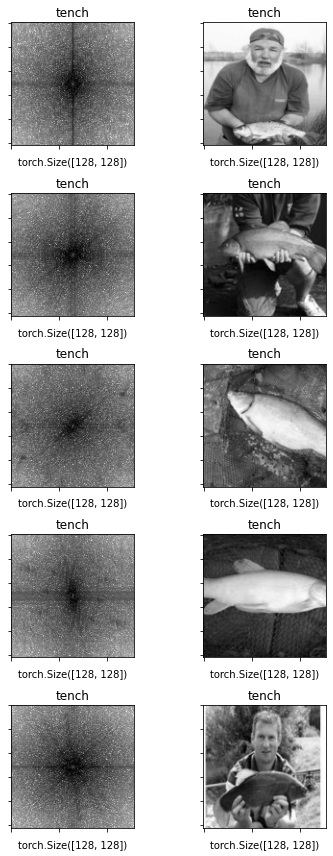

In [23]:
# screen for a particular digit/category

# get random batch
kxb, yb = k_dls.one_batch()
kxb, yb = to_cpu(kxb), to_cpu(yb)

# screen for digit/categpry
digit = 9

# x's,y's corresponding to digit 
kxbd = kxb[yb==digit] if digit != -1 else kxb
ybd  =  yb[yb==digit] if digit != -1 else kxb
print(f"Digit {digit} batch: {kxbd.shape}, {ybd.shape}")

# see idxs corresponding to digits
idxs = np.array(range(0, bs))[yb==digit]
print(f"Indices of {digit} in batch: {idxs[:10]}")

# decodes
rev_kxbd = apply(Complex2Channel().decodes(kxbd), TensorTfms.batch_k2real(onesided=False))
print(f"Batch kspace2img: tensor of shape {rev_kxbd.shape}")

# kspace abs
abs_kxbd = apply(Complex2Channel().decodes(kxbd), TensorTfms.log_abs, pre=TensorTfms.t_abs)
print(f"Batch log abs kspace: tensor of shape {abs_kxbd.shape}")

# plot item in batch

# select slice
nb = min(5, len(ybd))
bslice = slice(0,nb)

# set titles/order of images to plot
titles = [x for i in range(nb) for x in [f"{k_dls.vocab[ybd[i]]}",  f"{k_dls.vocab[ybd[i]]}"]]
imgs   = [x for i in range(nb) for x in [abs_kxbd[i], rev_kxbd[i]]]

# plot
plot(imgs, titles, nrows=nb, ncols=2, figsize=(6,12))

## Mean & STD 

(sparse k space though)

In [24]:
xb,yb = k_dls.one_batch()
xb,yb = to_cpu(xb), to_cpu(yb)

print(xb.shape, yb.shape)

# Most of kspace has 0 amplitude/phase (sparse) -- not normally distributed
xb.mean(dim=[0,2,3]),xb.std(dim=[0,2,3])

torch.Size([64, 2, 128, 128]) torch.Size([64])


(TensorImageBW([6.6298e-12, 4.1361e-03]), TensorImageBW([0.1590, 0.4929]))

## kspace2polar

perhaps easier for linear conv to pick up on important patterns

From SO: OpenCV 3.4 can do this now pretty easily with warpPolar()

In [0]:
def convert_to_polar():
  pass

# Architecture

Arch -- wave2letter Audio spectogram arch

CNN - Simple, no max pooling. Conv consists of 2dconv + batchnorm + activation ReLU. Assume resize to 128x128.

In [0]:
# CNNs

# conv layer consists of 2dconv + batchnorm + activation ReLU
def conv(ni, nf, ks=3, act=True):
  layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
  layers.append(nn.BatchNorm2d(nf))
  if act: layers.append(nn.ReLU())
  return nn.Sequential(*layers)

# simple cnn = stride 2, 3x3 kernel conv layers
def get_simple_cnn(c_in, n_out, sz, intro_nf=8, intro_ks=5):
  layers = []
  # add intro layer (size 2)
  if sz > 2: 
    layers.append(conv(c_in, nf=intro_nf, ks=intro_ks))
    curr_ni, curr_sz = intro_nf, sz//2
  # add middle layers (stride 2: double #input features, halve size)
  while curr_sz >= 4:
    layers.append(conv(curr_ni, curr_ni*2))
    curr_ni, curr_sz = curr_ni*2, curr_sz//2
  # add final stride-2 output layer & flatten
  layers += [conv(curr_ni, n_out, act=False), Flatten()]
  return nn.Sequential(*layers)
  
# DEFINE CNN & RESNET

# greyscale-1 input channel, complex kspace-2 input channels
simple_cnn   = get_simple_cnn(c_in=1, n_out=10, sz=batch_sz) 
k_simple_cnn = get_simple_cnn(c_in=2, n_out=10, sz=batch_sz)

# specify resnet with desired number of input channels/output features
base_resnet = xresnet34
k_resnet   = base_resnet(c_in=2, n_out=10)
resnet     = base_resnet(c_in=1, n_out=10)

Test arch works

In [27]:
# all arch/dls
test_archs = [simple_cnn, resnet, k_simple_cnn, k_resnet]
test_dls   = [im_dls, k_dls, k_abs_dls]

# set arch/dl pair to test
arch_idx,dl_idx = 0,0

# test learning with given arch on given dls
arch,dls = test_archs[arch_idx].cpu(), test_dls[dl_idx]
xb,yb = dls.one_batch()
xb,yb = to_cpu(xb), to_cpu(yb)
output = arch(xb)
print(f"input:  {xb.shape}\noutput: {output.shape},\npreds: {output[0]}")

input:  torch.Size([64, 1, 128, 128])
output: torch.Size([64, 10]),
preds: tensor([-0.8192, -0.8311, -1.3084, -0.1870, -1.3331, -1.3407,  1.0576,  0.4254,
        -0.2104,  0.0071], grad_fn=<SelectBackward>)


# Learn

In [0]:
from fastai2.callback.hook import *

# set callbacks
cbs = [] #ActivationStats(with_hist=True)

# get learner w/given arch + dls + loss_func
def get_learner(dls, arch, loss_func = F.cross_entropy):
  return Learner(dls, arch.cuda(), loss_func, metrics=accuracy, cbs=cbs)

# Define learners

# learn in image space
learn_cnn    = get_learner(im_dls, simple_cnn)
learn_resnet = get_learner(im_dls, resnet)

# learn in k space
k_learn_cnn    = get_learner(k_dls, k_simple_cnn)
k_learn_resnet = get_learner(k_dls, k_resnet)

# learn in k_log_abs space (one-channel input so simple_cnn & resnet)
k_abs_learn_cnn    = get_learner(k_abs_dls, simple_cnn)
k_abs_learn_resnet = get_learner(k_abs_dls, resnet)

# learn.summary()

# EXPORT
# save model's trained weights
def export(learn, fname, stage): 
  learn.export(f"{EXPORT_DIR}/{fname}-{stage}-export.pkl")

def load(fname, stage, cpu=False):
  return load_learner(f"{EXPORT_DIR}/{fname}-{stage}-export.pkl", cpu=cpu)

# Train

Baseline random: predict 1 out of 10 classes, expect 10% accuracy from random predictions.

Outcomes:

| Space     | Learner            | Accuracy | Time per Epoch | LR     | n_epoch | momentum | arch      |
|-----------|--------------------|----------|----------------|--------|---------|----------|-----------|
| image     | learn_cnn          | 62.75%   | 27sec               | 1e-3    | 5      | 1cycle   | xresnet34 |
| image     | learn_resnet       | 75.01%   | 34sec               | 2e-3 | 5       | 1cycle   | xresnet34 |
| complex k | k_learn_cnn        | 54.32%   | 28sec          | 0.27   | 5       | 1cycle   | xresnet34 |
| complex k | k_learn_resnet     | 60.89%   | 1min 31sec          | 2e-3 | 5       | 1cycle   | xresnet34 |
| log abs k | k_abs_learn_cnn    | 51.26%   | 27sec          | 0.23   | 5       | 1cycle   | xresnet34 |
| log abs k | k_abs_learn_resnet | 55.31%   | 33sec     | 2e-3   | 5       | 1cycle   | xresnet34 |


- learn_cnn: learn.fit_one_cycle(n_epoch=1, lr=0.6), accuracy 93.74%
- learn_resnet: learn.fit_one_cycle(n_epoch=1, lr=1.5e-2), accuracy 97.89%

- k_learn_cnn, learn.fit_one_cycle(n_epoch=1, lr=0.33), accuracy 92.05% - time per epoch: 51sec
- k_learn_resnet, learn.fit_one_cycle(n_epoch=1, lr=5.3e-3), accuracy 96.25% - time per epoch: 55sec

- k_abs_learn_cnn, learn.fit_one_cycle(n_epoch=1, lr=0.33), accuracy 63.71% - time per epoch: 52sec
- k_abs_learn_resnet, learn.fit_one_cycle(n_epoch=1, lr=0.03), accuracy 73.87% - time per epoch: 1min 59sec

## im space cnn

In [0]:
# # to load from saved version:
# learn = load("learn_cnn_no_aug", "epoch-5")
# learn.dls=learn_cnn.dls

SuggestedLRs(lr_min=0.2290867567062378, lr_steep=0.0063095735386013985)

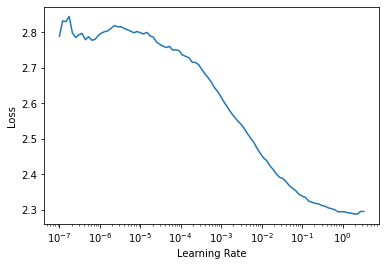

In [29]:
learn = learn_cnn
learn.lr_find()

# learn.summary()

In [30]:
learn.fit_one_cycle(n_epoch=5, lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.980742,1.899517,0.330446,00:27
1,1.667020,1.596420,0.472102,00:27
2,1.463947,1.508429,0.494522,00:27
3,1.347570,1.285852,0.589554,00:28
4,1.272114,1.236955,0.617834,00:27


In [0]:
export(learn, "learn_cnn_no_aug", "epoch-5")

## im sp resnet

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=0.0003981071640737355)

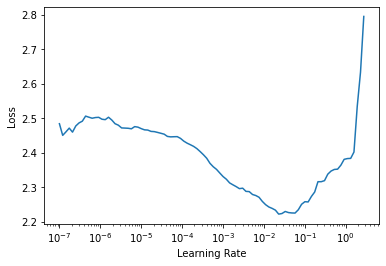

In [0]:
learn = learn_resnet
learn.lr_find()

In [0]:
learn.fit_one_cycle(n_epoch=5, lr=2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.679066,2.198514,0.355924,00:34
1,1.265978,1.624911,0.510318,00:34
2,1.028699,0.957301,0.680764,00:33
3,0.861215,0.824852,0.736815,00:33
4,0.754670,0.767734,0.750064,00:34


In [0]:
export(learn, "learn_resnet_no_aug", "epoch5")

## kspace cnn

SuggestedLRs(lr_min=0.2754228591918945, lr_steep=0.00015848931798245758)

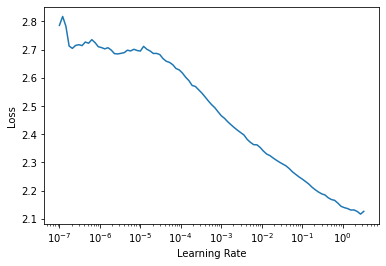

In [0]:
learn = k_learn_cnn
learn.lr_find()

In [0]:
learn.fit_one_cycle(n_epoch=5, lr=0.27)

epoch,train_loss,valid_loss,accuracy,time
0,1.918355,1.964417,0.290701,00:28
1,1.648122,1.652671,0.438726,00:28
2,1.541369,1.544602,0.468280,00:27
3,1.464210,1.402949,0.533248,00:27
4,1.404009,1.381637,0.543185,00:27


In [0]:
export(learn, "k_learn_cnn_no_aug", "epoch5")

## kspace resnet

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=0.002511886414140463)

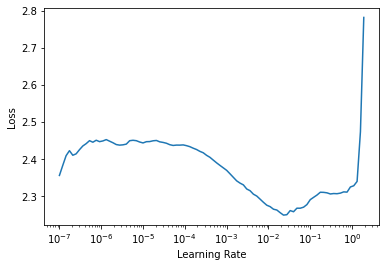

In [0]:
learn = k_learn_resnet
learn.lr_find()

In [0]:
learn.fit_one_cycle(n_epoch=5, lr=2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.910409,3.634456,0.217325,01:31
1,1.552334,1.517352,0.480764,01:31
2,1.383424,1.292485,0.560255,01:31
3,1.244521,1.220755,0.590828,01:32
4,1.199688,1.162281,0.608917,01:31


In [0]:
export(learn, "k_learn_resnet", "epoch5")

## kspace abs cnn

SuggestedLRs(lr_min=0.2290867567062378, lr_steep=0.0008317637839354575)

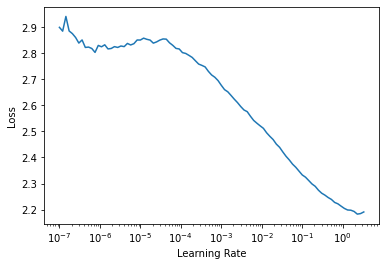

In [0]:
learn = k_abs_learn_cnn
learn.lr_find()

In [0]:
learn.fit_one_cycle(n_epoch=5, lr=0.23)

epoch,train_loss,valid_loss,accuracy,time
0,1.914114,1.876701,0.339618,00:27
1,1.628206,2.277196,0.270064,00:27
2,1.523328,1.536377,0.479236,00:27
3,1.455105,1.449604,0.512611,00:27
4,1.413163,1.432026,0.512611,00:27


## kspace abs resnet

SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.00015848931798245758)

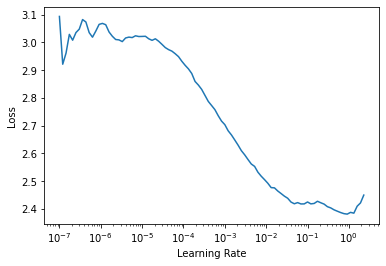

In [0]:
learn = k_abs_learn_resnet
learn.lr_find()

In [0]:
learn.fit_one_cycle(n_epoch=5, lr=2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.777845,1.927378,0.324076,00:33
1,1.549619,1.528429,0.464204,00:33
2,1.442735,1.527989,0.451975,00:33
3,1.342948,1.366364,0.527134,00:33
4,1.286723,1.294248,0.553121,00:33


In [0]:
#learn.activation_stats.plot_layer_stats(-2)
#learn.activation_stats.plot_layer_stats(0)

# Push exported files :)


# Old

In [0]:
# for Imagenette data

# convert filename stem to category
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

y_tfms = [parent_label, lbl_dict.__getitem__, Categorize]


In [0]:
# save original shape to IRFFT can umambiguously decode
class SaveShape(Transform):
  order = 12

  # excluding batch dimension
  def save_shape(t:Tensor):
    t.set_meta({"orig_shape": t.shape[-2:]})
    return t

In [0]:
# take dataset item (real img, category), convert to (k arr, category)
class Real2ComplexKOneSided(Transform):
  order = 13 # needs to run after save shape

  def encodes(self, t:Tensor): return apply(t, TensorTfms.real2k)


  def decodes(self, t_k:Tensor):
    t_k_abs         = apply(t_k, TensorTfms.t_abs)
    t_k_log_abs     = apply(t_k_abs, TensorTfms.log_abs)

    orig_shape = t_k.get_meta("orig_shape")
    t_real     = apply(t_k, TensorTfms.k2real(s=orig_shape))
    
    return ShowK(t_k_log_abs, t_real)

In [0]:
# k tensor that knows how to show itself
class K():
  def __init__(self, k, orig_shape):
    self.k, self.orig_shape = k, orig_shape

  def show(self, ctx=None, **kwargs): 
    rev_img = apply(self.k, TensorTfms.k2real(self.orig_shape))
    show_image(rev_img, cmap = "gray", title = "IRFFT", ctx=ctx, **kwargs)

  def to_tensor(self): return self.k

In [0]:
# convert original img arr to k space
class KTfm(Transform):
  
  # store orig shape so it can be decoded correctly (for showing purposes)
  def encodes(self, arr)->Tensor:
    return K(apply(arr, TensorTfms.real2k), arr.shape)

In [0]:
# permute tensor: HW(Complex) to (Complex)HW
class Permute(Transform):
  order = 1
  def encodes(self, t:Tensor):
    if t.size(-1) == 2: return t.transpose(-1,-3).transpose(-1,-2)
    return t

  def decodes(self, t:Tensor):
    if t.size(-1) == 2: return t.transpose(-1,-2).transpose(-1,-3)
    return t

## Old Viz

In [0]:
# shows real & kspace together
class ShowK(Tuple):

  def show(self, ctx=None, **kwargs): 
    k,real = self
    line = k.new_zeros(k.shape[0], 10)
    return show_image(torch.cat([k,line,real], dim=1), title = "K & Real", ctx=ctx, **kwargs)

In [0]:
xb,yb = dls.one_batch()

In [0]:
xb.shape

In [0]:
t_k = tensor(xb[0])
t_k.shape

In [0]:
t_k = Complex2Channel().decodes(t_k)
t_k.shape

In [0]:
show_k = Real2ComplexK().decodes(t_k)
type(show_k)

In [0]:
show_k.show(figsize=(6,6), cmap="gray_r")